**Цель проекта**

Построить модель для предсказания тональности текста

## Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import torch
import torch.nn as nn

from pymystem3 import Mystem

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.probability import FreqDist
import re

from wordcloud import WordCloud, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

from torchmetrics import F1Score

In [ ]:
sns.set()

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


## Предобработка и исследовательский анализ данных

попробовать nltk_tag

добавить pos-теги

перевод в юникод на латинских символах не нужен

*Unnamed: 0* - лишний столбец, который содержит индексы. Удалим его.

In [ ]:
data = data.drop(columns=['Unnamed: 0'], axis=1)

Приведем все тексты к нижнему регистру.

In [ ]:
data['text'] = data['text'].str.lower()

Проверим, есть ли в датасете пропуски или дубликаты.

In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
data.duplicated().sum()

45

Пропусков нет. Но есть дубликаты, удалим их.

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

Очистим текст от лишних символов, используя регулярные выражения.

In [ ]:
def edit_text(text):
  return ' '.join(re.sub(r'[^a-zA-Z\' ]', ' ', text).split())

In [ ]:
data['text'] = data['text'].apply(edit_text)

Лемматизируем тексты.

In [ ]:
def lemmatize_text(text):
  return ''.join(lemmatizer.lemmatize(text))

In [ ]:
lemmatizer = Mystem()

In [ ]:
data['text'] = data['text'].apply(lemmatize_text)

In [ ]:
data.duplicated().sum()

1198

После преобразований появились дубликаты. Удалим их.

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Посмотрим на распределение таргета.

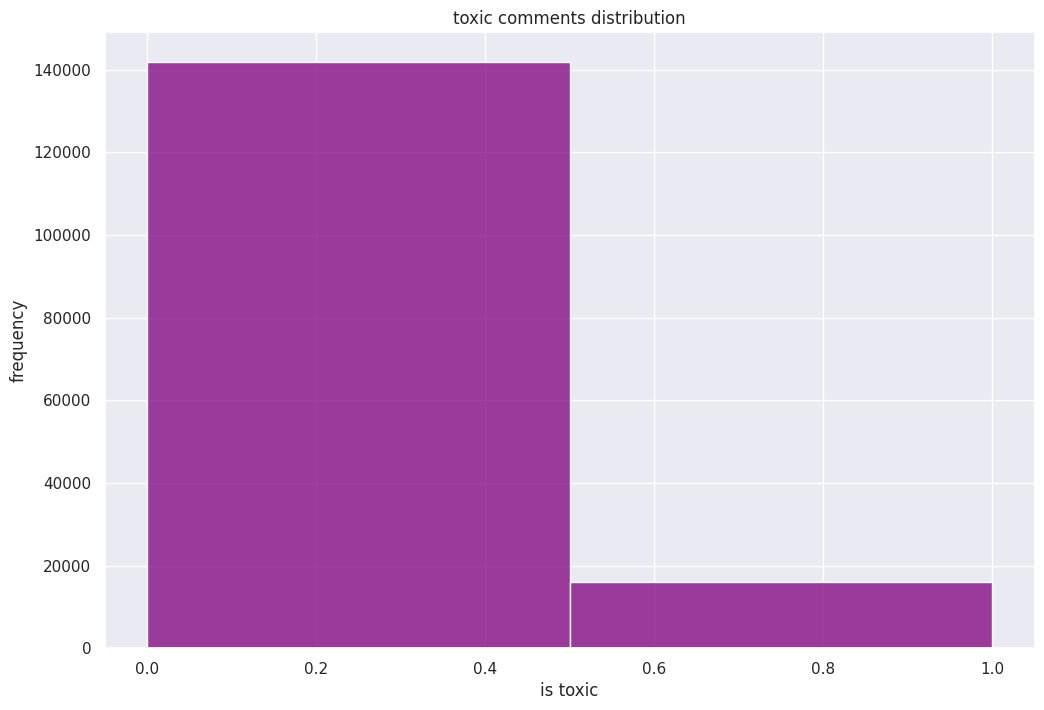

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['toxic'], ax=ax_hist, color='purple', bins=2)

ax_hist.set(xlabel='is toxic')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='toxic comments distribution')
plt.show()

In [ ]:
data['toxic'].value_counts(normalize=True)

0    0.898335
1    0.101665
Name: toxic, dtype: float64

Токсичных комментариев 10% от всего количества. Это сильный дисбаланс.

Посмотрим на распределение длин текстов.

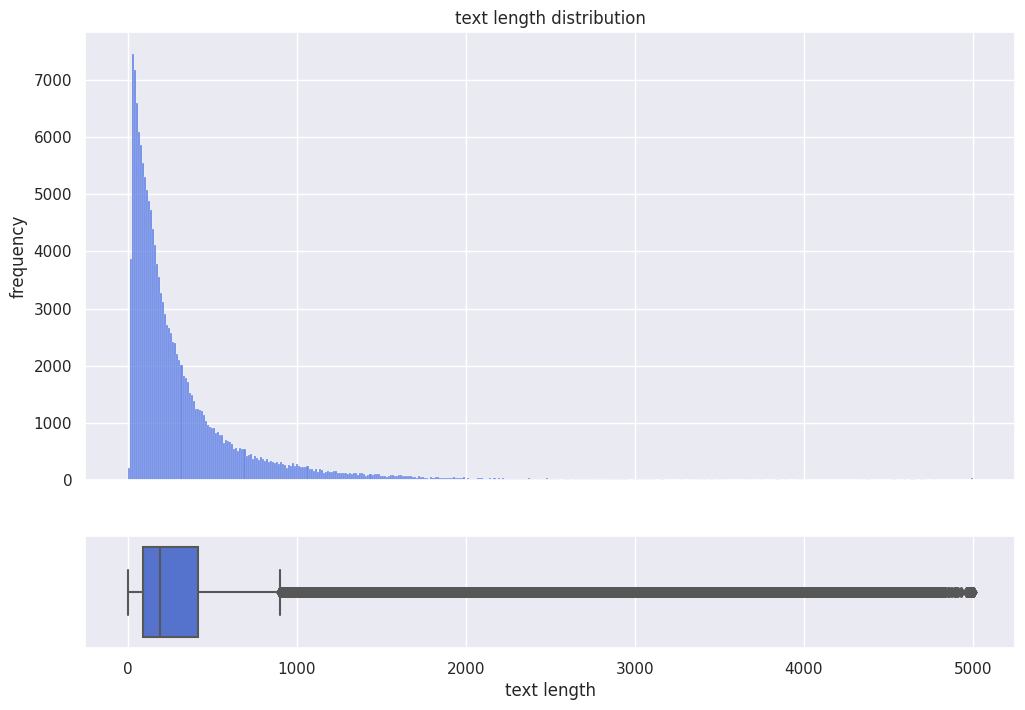

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['text'].apply(lambda x: len(x)), ax=ax_hist, color='royalblue')
sns.boxplot(x=data['text'].apply(lambda x: len(x)), ax=ax_box, color='royalblue')

ax_box.set(xlabel='text length')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='text length distribution')
plt.show()

Длина текстов распределена экспоненциально.

Получим облака слов для токсичных и нетоксичных комментариев.

In [ ]:
toxic_data = data[data['toxic'] == 1]
non_toxic_data = data[data['toxic'] == 0]

In [ ]:
words = toxic_data['text'].str.split()
allwords = []
for wordlist in words:
  allwords += wordlist

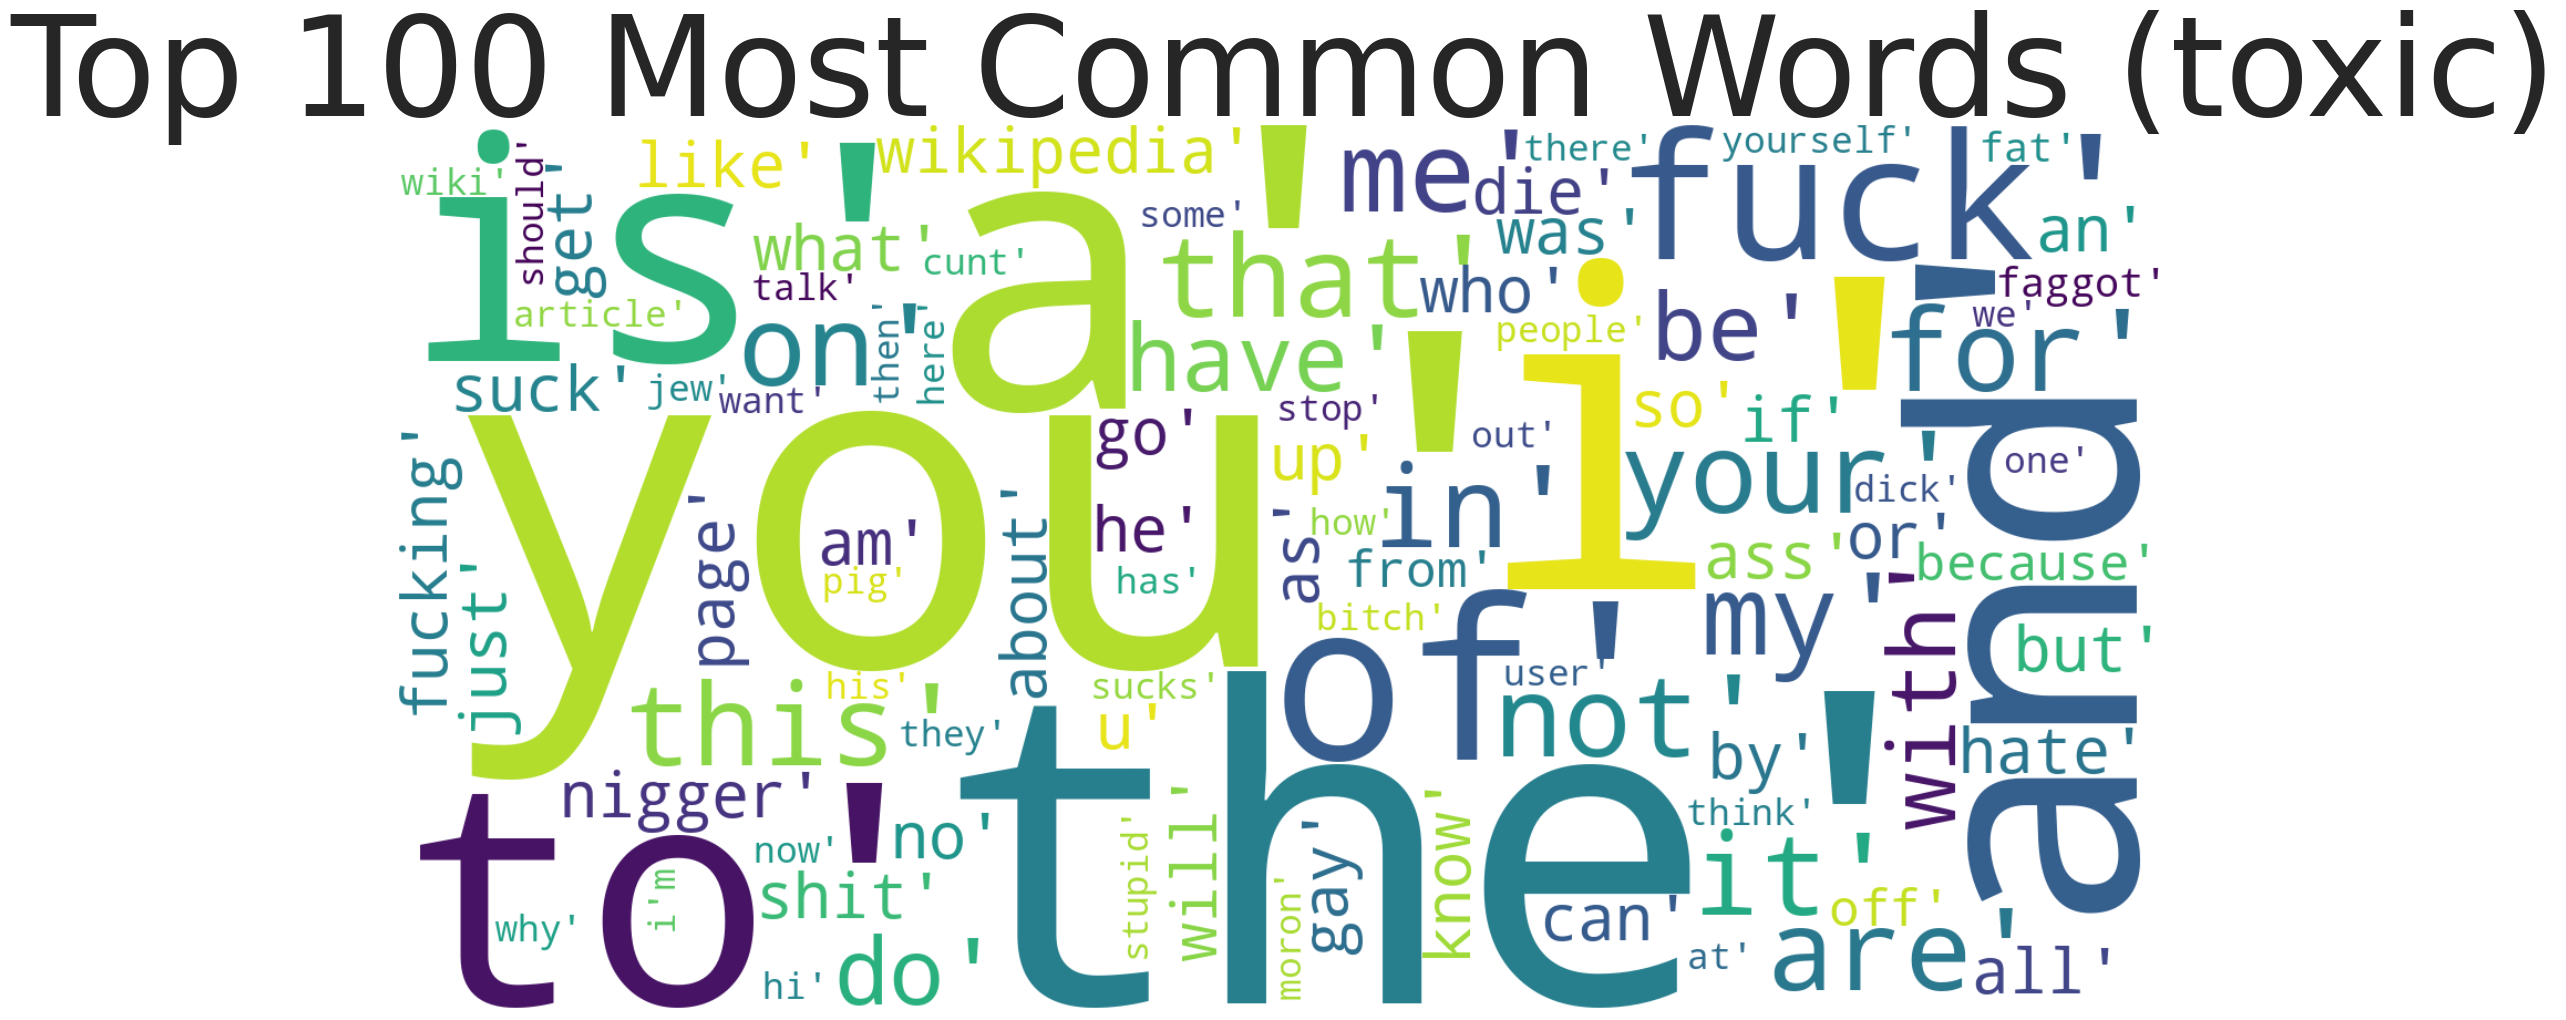

In [ ]:
most_common_words = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800, background_color='white').generate(str(most_common_words))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words (toxic)', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
words = non_toxic_data['text'].str.split()
allwords = []
for wordlist in words:
  allwords += wordlist

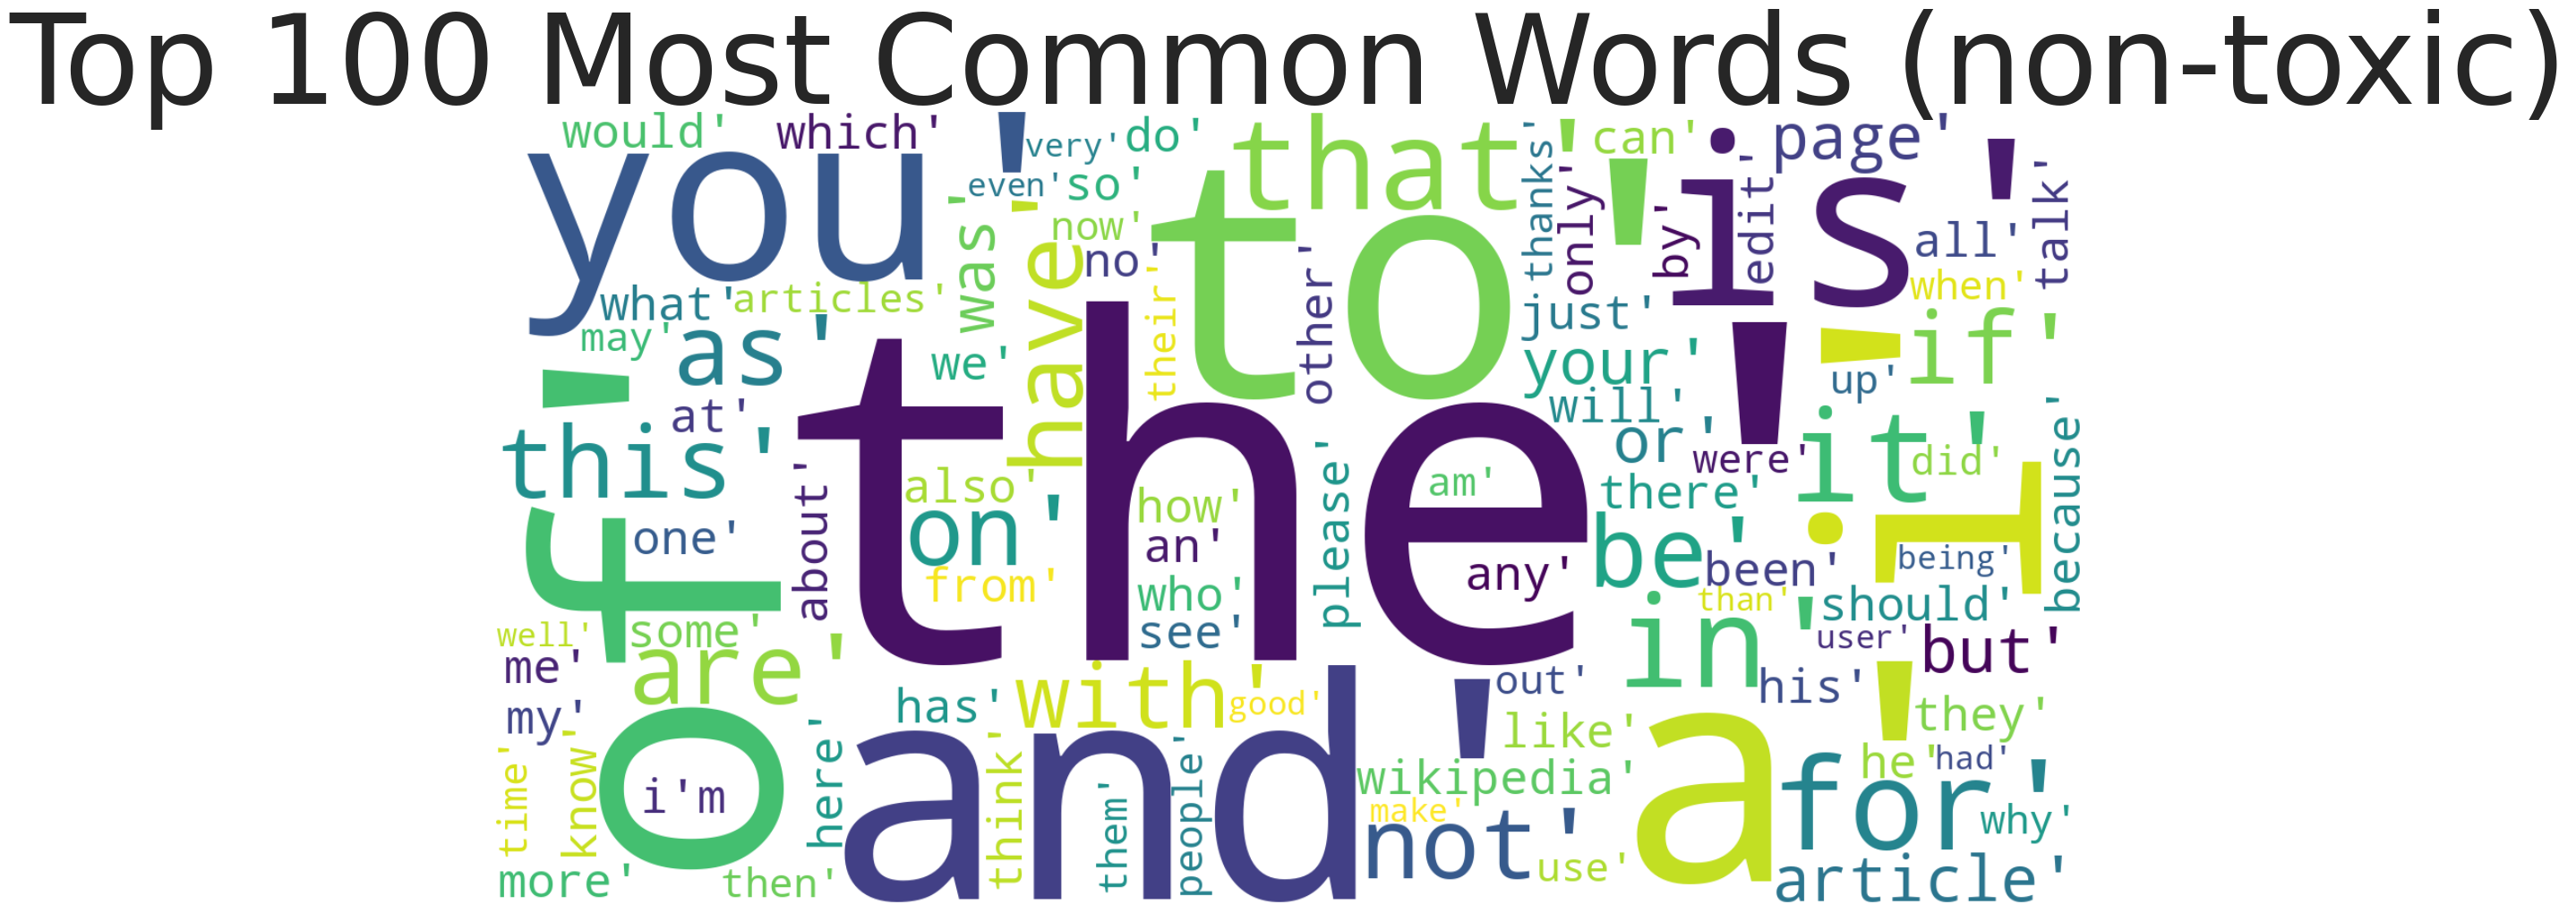

In [ ]:
most_common_words = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800, background_color='white').generate(str(most_common_words))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words (non-toxic)', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

## Обучение моделей.

Поделим датасет на обучающую и тестовую выборку в соотношении 1:4.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['toxic'], test_size=0.2, random_state=987)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((126439,), (31610,), (126439,), (31610,))

Создадим матрицу со значениями TF-IDF по корпусу комменатариев.

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [ ]:
train_tf_idf = count_tf_idf.fit_transform(x_train)
test_tf_idf = count_tf_idf.transform(x_test)

In [ ]:
train_tf_idf.shape, test_tf_idf.shape

((126439, 148213), (31610, 148213))

Обучим модель логистической регрессии.

In [ ]:
log_reg = LogisticRegression(random_state=987)

In [ ]:
log_reg.fit(train_tf_idf, y_train)

LogisticRegression(random_state=987)

In [ ]:
pred = log_reg.predict(test_tf_idf)
print("F1:", f1_score(y_test, pred))

F1: 0.7233483483483484


По метрике F1 модель получила скор 0.72. Попробуем подобрать для нее наилучшие параметры.

In [ ]:
def objective(trial):
  params = {"max_iter": trial.suggest_int("max_iter", 10, 1300),
             'C': trial.suggest_int('C', 1, 15),
            }
  model = LogisticRegression(**params, random_state=987)
  model.fit(train_tf_idf, y_train)
  predicted_test = model.predict(test_tf_idf)
  return f1_score(y_test, predicted_test)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=20)

[I 2023-12-22 10:58:17,173] A new study created in memory with name: no-name-fe262749-8c98-4182-baed-2e59f67c8dd8
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale

In [ ]:
print('best params:', study.best_params)

best params: {'max_iter': 50, 'C': 15}


In [ ]:
best_model = LogisticRegression(**study.best_params, random_state=987)

In [ ]:
best_model.fit(train_tf_idf, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=15, max_iter=50, random_state=987)

In [ ]:
pred = best_model.predict(test_tf_idf)
print("F1:", f1_score(y_test, pred))

F1: 0.7746020879685093


После подбора параметров модель показывает намного лучший скор 0.77.

Обучим модель градиентного бустинга.

In [ ]:
cat_boost = CatBoostClassifier(verbose=50, random_state=987)

In [ ]:
cat_boost.fit(train_tf_idf, y_train)

Learning rate set to 0.081365
0:	learn: 0.6072749	total: 5.57s	remaining: 1h 32m 41s
50:	learn: 0.1999715	total: 2m 28s	remaining: 45m 55s
100:	learn: 0.1775269	total: 4m 49s	remaining: 42m 57s
150:	learn: 0.1641647	total: 7m 14s	remaining: 40m 45s
200:	learn: 0.1547533	total: 9m 32s	remaining: 37m 56s
250:	learn: 0.1477955	total: 11m 52s	remaining: 35m 26s
300:	learn: 0.1419265	total: 14m 11s	remaining: 32m 57s
350:	learn: 0.1372298	total: 16m 33s	remaining: 30m 37s
400:	learn: 0.1329846	total: 18m 53s	remaining: 28m 13s
450:	learn: 0.1296320	total: 21m 11s	remaining: 25m 48s
500:	learn: 0.1265672	total: 23m 35s	remaining: 23m 29s
550:	learn: 0.1236394	total: 25m 52s	remaining: 21m 5s
600:	learn: 0.1212302	total: 28m 10s	remaining: 18m 42s
650:	learn: 0.1188719	total: 30m 34s	remaining: 16m 23s
700:	learn: 0.1169194	total: 32m 51s	remaining: 14m
750:	learn: 0.1150672	total: 35m 8s	remaining: 11m 39s
800:	learn: 0.1131440	total: 37m 31s	remaining: 9m 19s
850:	learn: 0.1113797	total: 39

In [ ]:
pred = cat_boost.predict(test_tf_idf)
f1 = f1_score(y_test, pred)
print('F1 score:', f1)

F1 score: 0.7481521543176493


Модель градиентного бустинга получила меньший скор - 0.74.

**ВЫВОД**

**Был загружен и предобработан датасет с текстами комментариев для задачи классификации их на позитивные и негативные. Тексты были лемматизированы и для них сгенерирована матрица TF-IDF.**

**Были обучены модели логистической регрессии и градиентного бустинга. Лучшего показателя метрики F1 добилась модель логистической регрессии. F1 = 0.77**